In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from EM_dataset import EM_Data
from keras.models import Model
from keras.layers import Input
from keras.callbacks  import CSVLogger, ModelCheckpoint
from keras import backend as K
from keras.optimizers import RMSprop
from keras.utils import multi_gpu_model

from sklearn import metrics

import os
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import my_model

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Using TensorFlow backend.


In [3]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
K.set_session(tf.Session(config=config))

In [4]:
print(os.environ["CUDA_VISIBLE_DEVICES"], K.image_dim_ordering())

4 th


In [5]:
from cremi_python.cremi.evaluation import rand

In [6]:
def adapted_rand(gt_seg, pred_seg):
    from cremi_python.cremi.evaluation import rand
    return rand.adapted_rand(gt_seg, pred_seg)

In [7]:
def savePredictIMG(Y, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    dim = Y.ndim      
    slices = Y.shape[1]
    if dim == 4:
        row = Y.shape[2]
        col = Y.shape[3]
    elif dim ==5:
        row = Y.shape[3]
        col = Y.shape[4]
    else:
        raise ValueError('prob map stack demension must between 4-5, you give {}'.format(dim))
        
    for i in range(slices):
        im = Y[0, i ,0].reshape(row, col) if dim == 5 else Y[0, i].reshape(row, col)
        # hehe, 反反反
        im = 1 - im
        fig = plt.imshow(im, cmap='Greys')
        
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
#         file_name = directory+'/prdict_{}.pdf'.format(i)
#         print('write to '+ file_name)
#         plt.savefig(file_name, bbox_inches ='tight', pad_inches=0)
        
        file_name = directory +'/prdict_{}.png'.format(i)
        print('write to '+ file_name)
        if os.path.isfile(file_name):
            os.remove(file_name)
        plt.savefig(file_name, bbox_inches='tight', pad_inches = 0)
#         plt.show()

In [8]:
def save_prob_to_hd5(Y, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    dim=Y.ndim
    if dim == 4:
        row = Y.shape[2]
        col = Y.shape[3]
    elif dim ==5:
        row =Y.shape[3]
        col =Y.shape[4]
    else:
        raise ValueError('prob map stack demension must between 4-5, you give {}'.format(dim))
    assert Y.shape[0] == 1, "can't save prob data haveing more than 1 sample"
    depth = Y.shape[1]

    Y = Y.reshape(depth,row,col)
    Y = np.transpose(Y,(1,2,0))
#     print(Y.shape)
    d_file = directory+'/prob.h5'
    h5f = h5py.File(d_file,'w')
    dset = h5f.create_dataset('data', data=Y)
    h5f.close()

In [9]:
model_dict = {}
models = {}
model_dict['deepEM3D'] = ['deepEM3D', my_model.timeDist_DeepEM3D_Net]
models['deepEM3D'] = 'deepEM3D'
model_name = 'deepEM3D'

In [13]:
r = 1250
c = 1250
d = 5  # it seems using 10 will still get 20 result

EM_D = EM_Data(patch_shape=(r, c, d), 
               data_dir='DATA/CREMI/', data_file='A_train.h5')

loading data file from: DATA/CREMI/A_train.h5


In [14]:
EM_D.image_size

(1250, 1250, 125)

In [29]:
if not model_name in model_dict:
    print("can not find model {}".format(model_name_key))

# initialize model
model_name = model_dict[model_name][0]
model_create_func = model_dict[model_name][1]
ip = Input(shape=(None, 1, r, c))
output = model_create_func(ip)
model  = Model(ip, output)

(?, ?, 1, 1250, 1250)
(?, ?, 1250, 1250, 1)
(?, ?, 1, 1264, 1264)
(?, ?, 192, 632, 632) (?, ?, 384, 316, 316) (?, ?, 1152, 158, 158) (?, ?, 2144, 79, 79)


In [30]:
# load weights
weight_h5_file = './'+ model_name +'.h5'
if os.path.isfile(weight_h5_file):
    try:
        model.load_weights(weight_h5_file)
    except:
        print('the model {} can not  be loaded'.format(weight_h5_file))
        pass

In [38]:
%%time
# prediction
predict_depth = 25.0
iter_num = int(math.ceil(predict_depth/float(d)))
for i in range(iter_num):
    X_test, Y_test = EM_D.load_valid_data_5D(start_slice=i*d, slices=d)
    # print("valid X Y input shape: ", X_test.shape, Y_test.shape)

    # check Y_test unique is 0, 255 is 0, 1
    # print("Y_test unique: ", np.unique(Y_test))

    Y_predict = model.predict(X_test)
    # print("predict output shape: ", Y_predict.shape)
    # print "predict {}".foramt(i)
    if i == 0:
        Y_T = Y_test
        Y_P = Y_predict
    else:
        Y_T = np.concatenate((Y_T, Y_test), axis=1)
        Y_P = np.concatenate((Y_P, Y_predict), axis=1)

CPU times: user 5min 57s, sys: 1min 25s, total: 7min 23s
Wall time: 57.6 s


In [46]:
print("Y_Predict shape: ", Y_P.shape)
print("Y_Test shape: ", Y_T.shape)

Y_Predict shape:  (1, 125, 1, 1250, 1250)
Y_Test shape:  (1, 125, 1, 1250, 1250)


In [40]:
# only get the first channel, second one is the reverse
Y_P = Y_P[:, :, 0]

In [45]:
Y_P = np.resize(Y_P, (1, 125, 1, 1250, 1250))

In [ ]:
# flatten
P = Y_P.reshape(Y_P.size,)
T = Y_T.reshape(Y_T.size,)
Accuracy = np.mean(np.round(P)==T)

# Input contains NaN, infinity or a value too large for dtype('float32').
# check if there are many such things
# print("check nan in prediction: ", np.where(np.isnan(P)))
# P = np.nan_to_num(P)
# print("check nan in prediction: ", np.where(np.isnan(P)))

fpr, tpr, thresholds = metrics.roc_curve(T, P)
auc = metrics.auc(fpr, tpr)
# scores = model.evaluate(X_test, Y_test, verbose=0)

In [48]:
r = 1250
c = 1250
d = 125

Y_3D = Y_P.reshape(d, r, c)
#Y_3D=np.transpose(Y_3D,(1,2,0))
Y_T3D = Y_T.reshape(d, r, c)
#Y_T3D =np.transpose(Y_3D,(1,2,3))

In [ ]:
print("Final label shape: ", Y_T3D.shape, Y_3D.shape)

In [51]:
%%time
p_r_e = adapted_rand(Y_T3D.astype(int), np.round(Y_3D).astype(int))
# print('ACC={} , AUC ={}, pixel_rand_err ={}'.format(Accuracy, auc, p_r_e))
print('ACC={} , pixel_rand_err ={}'.format(Accuracy, p_r_e))

ACC=0.0 , pixel_rand_err =0.9898038994820748


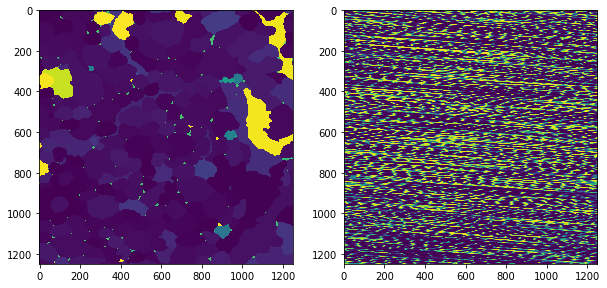

In [54]:
d = 0
figure, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(Y_T3D[d])
ax[1].imshow(Y_3D[d])

### SAVING RESULTS

write to ./deepEM3Dvalid_prob_img/prdict_0.png
write to ./deepEM3Dvalid_prob_img/prdict_1.png
write to ./deepEM3Dvalid_prob_img/prdict_2.png
write to ./deepEM3Dvalid_prob_img/prdict_3.png
write to ./deepEM3Dvalid_prob_img/prdict_4.png
write to ./deepEM3Dvalid_prob_img/prdict_5.png
write to ./deepEM3Dvalid_prob_img/prdict_6.png
write to ./deepEM3Dvalid_prob_img/prdict_7.png
write to ./deepEM3Dvalid_prob_img/prdict_8.png
write to ./deepEM3Dvalid_prob_img/prdict_9.png
write to ./deepEM3Dvalid_prob_img/prdict_10.png
write to ./deepEM3Dvalid_prob_img/prdict_11.png
write to ./deepEM3Dvalid_prob_img/prdict_12.png
write to ./deepEM3Dvalid_prob_img/prdict_13.png
write to ./deepEM3Dvalid_prob_img/prdict_14.png
write to ./deepEM3Dvalid_prob_img/prdict_15.png
write to ./deepEM3Dvalid_prob_img/prdict_16.png
write to ./deepEM3Dvalid_prob_img/prdict_17.png
write to ./deepEM3Dvalid_prob_img/prdict_18.png
write to ./deepEM3Dvalid_prob_img/prdict_19.png


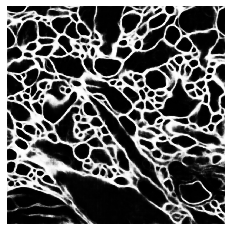

In [18]:
pred_img_folder = model_name

prob_folder ="./" + model_name + "valid_prob_img"
h5_folder   ="./" + model_name + "valid_prob_h5"

savePredictIMG(Y_P, prob_folder)
save_prob_to_hd5(Y_P, h5_folder)

### Check metric-Rand

In [18]:
Y_T3D = Y_T3D.astype(int)
Y_3D = np.round(Y_3D).astype(int)

In [33]:
segA = np.ravel(Y_T3D)
segB = np.ravel(Y_3D)
n = segA.size

n_labels_A = np.amax(segA) + 1
n_labels_B = np.amax(segB) + 1
print(n, n_labels_A, n_labels_B)

20971520 2 2


In [34]:
import scipy.sparse as sparse

ones_data = np.ones(n)

p_ij = sparse.csr_matrix((ones_data, (segA[:], segB[:])), shape=(n_labels_A, n_labels_B))

# won't include 0 row
a = p_ij[1:n_labels_A,:]
b = p_ij[1:n_labels_A,1:n_labels_B]
c = p_ij[1:n_labels_A,0].todense()
d = b.multiply(b)

print(a, '\n')
print(b, '\n')
print(c, '\n')
print(d, '\n')

  (0, 0)	1450995.0
  (0, 1)	15251406.0 

  (0, 0)	15251406.0 

[[1450995.]] 

  (0, 0)	232605384976836.0 



In [35]:
print(p_ij)

  (0, 0)	2968320.0
  (0, 1)	1300799.0
  (1, 0)	1450995.0
  (1, 1)	15251406.0


In [39]:
a_i = np.array(a.sum(1))
b_i = np.array(b.sum(0))
sumA = np.sum(a_i * a_i)
sumB = np.sum(b_i * b_i) + (np.sum(c) / n)
sumAB = np.sum(d) + (np.sum(c) / n)

precision = sumAB / sumB
recall = sumAB / sumA

fScore = 2.0 * precision * recall / (precision + recall)
are = 1.0 - fScore

are

0.09063140545645776